In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train_transaction = pd.read_csv('G:\Data Sets\IEEE\Train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('G:\Data Sets\IEEE\Test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('G:\Data Sets\IEEE\Train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('G:\Data Sets\IEEE\Test_identity.csv', index_col='TransactionID')
sample_submission = pd.read_csv('G:\Data Sets\IEEE\sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
del train_transaction, train_identity
gc.collect()
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
del test_transaction, test_identity
gc.collect

train=reduce_mem_usage(train)
test=reduce_mem_usage(test)
print('training set shape:', train.shape)
print('test set shape:', test.shape)

Mem. usage decreased to 668.22 Mb (66.2% reduction)
Mem. usage decreased to 583.43 Mb (65.6% reduction)
training set shape: (590540, 433)
test set shape: (506691, 432)


In [4]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [11]:
train.reset_index()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.000000,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.000000,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.500000,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.000000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.000000,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
test.reset_index()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3663554,18403323,57.937500,W,12839,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3663555,18403350,87.000000,W,16560,476.0,150.0,visa,126.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3663556,18403387,390.000000,W,15066,170.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3663557,18403405,103.937500,W,2803,100.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3663558,18403416,117.000000,W,12544,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
# cols_to_drop.remove('TransactionID')
cols_to_drop.remove('TransactionDT')

In [21]:
'TransactionID' in useful_features

False

In [23]:
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

152 features are going to be dropped for being useless


In [24]:
# New feature - decimal part of the transaction amount
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# Count encoding for card1 feature. 
# Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))
    
for feature in ['id_34', 'id_36']:
    if feature in useful_features:
        # Count encoded for both train and test
        train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    if feature in useful_features:
        # Count encoded separately for train and test
        train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
        test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))


In [25]:
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [30]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [29]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [31]:
del train
gc.collect()

10839

In [32]:
X.shape, test.shape

((590540, 298), (506691, 298))

In [33]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [34]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999998	valid_1's auc: 0.90504
Early stopping, best iteration is:
[1315]	training's auc: 1	valid_1's auc: 0.905218
Fold 1 finished in 0:04:37.197513
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999963	valid_1's auc: 0.92437
Early stopping, best iteration is:
[821]	training's auc: 0.999807	valid_1's auc: 0.924938
Fold 2 finished in 0:05:40.905233
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999525	valid_1's auc: 0.916118
Early stopping, best iteration is:
[1073]	training's auc: 0.9997	valid_1's auc: 0.916438
Fold 3 finished in 0:07:31.064231
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998145	valid_1's auc: 0.936278
Early stopping, best iteration is:
[1075]	training's auc: 0.998655	valid_1's auc: 0.9

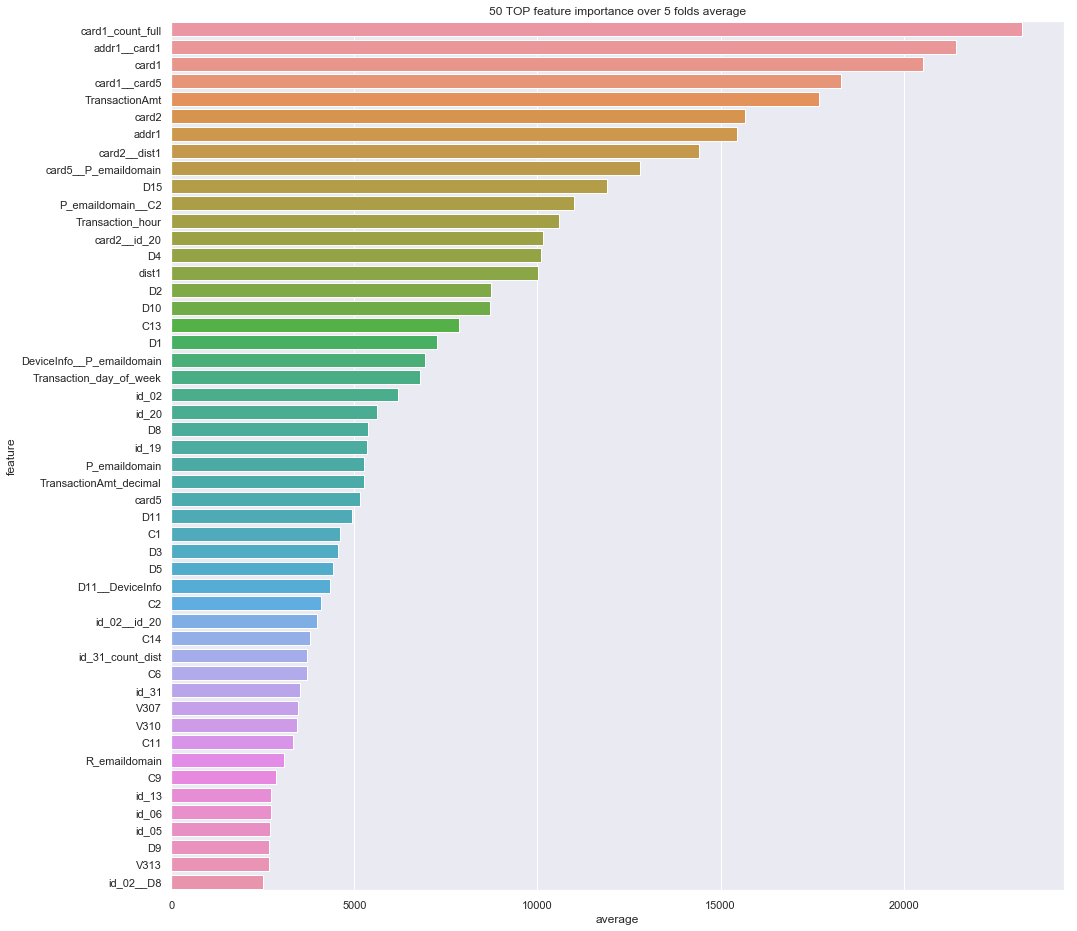

In [35]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [36]:
best_iter = clf.best_iteration

In [37]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3797454081646243, importance_type='split',
        learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.03454472573214212,
        min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_boost_round=1345, num_leaves=491,
        objective='binary', random_state=47, reg_alpha=0.3899927210061127,
        reg_lambda=0.6485237330340494, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [39]:
sample_submission['isFraud'] = clf.predict_proba(test)[:, 1]

In [45]:
sample_submission.to_csv('ieee_cis_fraud_detection_v2.csv', index=False)

In [44]:
sample_submission.reset_index(inplace=True)